In [1]:
from pyzotero import zotero
import os
import sys
from dotenv import load_dotenv
load_dotenv()
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from code_utils.zotero import get_data_from_zotero
from code_utils.glutton import get_doi_glutton
from code_utils.utils import get_doi_cleaned,aplatir
from code_utils.pickle import load_cache,write_cache
from code_utils.enriching_data_OpenAlex import get_countries_concepts_sdg,get_open_alex_data,get_open_alex_data_not_in_references

In [2]:
cached_openalex_data_ipbes = {}
cached_openalex_data_not_ipbes = {}

In [3]:
try:
    cached_openalex_data_ipbes = load_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_ipbes.pkl')
    cached_openalex_data_not_ipbes = load_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipbes.pkl')
except:
    write_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_ipbes.pkl')
    write_cache(cached_openalex_data_not_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipbes.pkl')

6607 data in cached openalex data
70 data in cached openalex data


Read IPBES references in zotero files

In [4]:
ZOTERO_KEY = os.getenv('ZOTERO_KEY')
IPBES_ZOTERO_ID = '2333077'
COLLECTION_IDS = ['8DQ8YFJI','JR5LKU4U','LBFNF62B','7IMYH9U3','DRZLUY9K','KTPTCAVF','UWNSUNXQ','BJGWRJAK','JT8FJXP6']
CHAPTER_IDS=['1','2.1','2.2','2.3','3','4','5','6','glossary']
ALL_COLLECTIONS={}

In [5]:
ALL_COLLECTIONS=get_data_from_zotero(ZOTERO_KEY,IPBES_ZOTERO_ID,COLLECTION_IDS,CHAPTER_IDS,ALL_COLLECTIONS)

In [6]:
df_ipbes_chap={}
for i in range(len(COLLECTION_IDS)):
    df_ipbes_chap[CHAPTER_IDS[i]]=pd.DataFrame(list(pd.DataFrame(ALL_COLLECTIONS[f'collection_chapter_{CHAPTER_IDS[i]}']).data))[['DOI','title','date','creators','tags']]
    df_ipbes_chap[CHAPTER_IDS[i]]['chap']=f'chap_{CHAPTER_IDS[i]}'
    print(f'{len(df_ipbes_chap[CHAPTER_IDS[i]][~pd.isna(df_ipbes_chap[CHAPTER_IDS[i]].DOI)])/len(df_ipbes_chap[CHAPTER_IDS[i]])*100} % doi available for chapter {CHAPTER_IDS[i]}')

63.2258064516129 % doi available for chapter 1
71.26436781609196 % doi available for chapter 2.1
79.26829268292683 % doi available for chapter 2.2
79.60199004975125 % doi available for chapter 2.3
81.64682539682539 % doi available for chapter 3
85.9103385178408 % doi available for chapter 4
73.2587064676617 % doi available for chapter 5
81.23682361208714 % doi available for chapter 6
37.90613718411552 % doi available for chapter glossary


Clean and enrich data 

In [7]:
df_ipbes=pd.concat(list(df_ipbes_chap.values())).reset_index()
del df_ipbes['index']

In [8]:
len(df_ipbes[~pd.isna(df_ipbes.DOI)])/len(df_ipbes)*100

77.36948241093435

In [9]:
df_ipbes.loc[pd.isna(df_ipbes.DOI),'DOI']=df_ipbes.loc[pd.isna(df_ipbes.DOI),:].progress_apply(get_doi_glutton, axis=1)

  0%|          | 0/2020 [00:00<?, ?it/s]

In [10]:
len(df_ipbes[~pd.isna(df_ipbes.DOI)])/len(df_ipbes)*100

89.27851221151691

In [11]:
df_ipbes.loc[:,'DOI']=df_ipbes.loc[:,'DOI'].apply(lambda x: get_doi_cleaned(x))
df_ipbes.loc[:,'DOI']=df_ipbes.loc[:,'DOI'].apply(lambda x: None if str(x)[:4]=='http' else x)
df_ipbes['freq']=1
df_ipbes=df_ipbes.rename(columns={'DOI':'doi'})

Enriching data through OpenAlex API integration

In [12]:
df_unique_doi=df_ipbes.groupby(by=['doi'], dropna=True).agg({'chap': lambda x: list(x), 'freq': 'sum'})
df_unique_doi=df_unique_doi.reset_index()

In [13]:
#get data_OpenAlex from the API 
df_unique_doi.apply(lambda row: get_open_alex_data(cached_openalex_data_ipbes,row['doi']), axis= 1)

0       [{'id': 'https://openalex.org/W1970666665', 'd...
1       [{'id': 'https://openalex.org/W2077652067', 'd...
2       [{'id': 'https://openalex.org/W2320183287', 'd...
3       [{'id': 'https://openalex.org/W1487177596', 'd...
4       [{'id': 'https://openalex.org/W1546680881', 'd...
                              ...                        
6599    [{'id': 'https://openalex.org/W2890993837', 'd...
6600    [{'id': 'https://openalex.org/W2029219906', 'd...
6601    [{'id': 'https://openalex.org/W2221413160', 'd...
6602    [{'id': 'https://openalex.org/W3124428460', 'd...
6603    [{'id': 'https://openalex.org/W3137011924', 'd...
Length: 6604, dtype: object

In [16]:
len(cached_openalex_data_ipbes)

6608

In [17]:
write_cache(cached_openalex_data_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_ipbes.pkl')

In [81]:
def get_countries_concepts_sdg(cached_openalex_data,row=True,ipcc=True,i=0):
    if ipcc:
        doi=row.doi
        if cached_openalex_data[doi]==[]:
            topics=[]
            data=[]
        elif (len(cached_openalex_data[doi])>1)&('topics' not in list(cached_openalex_data[doi][0].keys())):
            topics=cached_openalex_data[doi][1].get('topics')
            data=cached_openalex_data[doi][1]
        elif (len(cached_openalex_data[doi])==1)&('topics' in list(cached_openalex_data[doi][0].keys())):
            topics=cached_openalex_data[doi][0].get('topics')
            data=cached_openalex_data[doi][0]
    else:
        if isinstance(cached_openalex_data[i],list):
            if (len(cached_openalex_data[i])>1)&('topics' not in list(cached_openalex_data[i][0].keys())):
                topics=cached_openalex_data[i][1].get('topics')
                data=cached_openalex_data[i][1]
            if (len(cached_openalex_data[i])==0)&('topics' in list(cached_openalex_data[i][0].keys())):
                topics=cached_openalex_data[i][0].get('topics')
                data=cached_openalex_data[i][0]
        else:
            data=cached_openalex_data[i]
            if ('topics' in list(data.keys())):
                topics=data.get('topics')
            else:
                topics=[]
        doi=data.get('doi')
    if (data!=[]):
        authors=data.get('authorships')
        if authors!=[]:
            countries=list(set(aplatir([author.get('countries') for author in authors]))) 
        else:
            countries=[None]

        concepts=data.get('concepts')
        if concepts!=[]:
            concepts_names=[{'name': concept.get('display_name')} for concept in concepts]
        else:
            concepts_names=None

        if topics!=[]:
            topics_names=[{'name': topic.get('display_name')} for topic in topics]
        else:
            topics_names=None

        sdgs=data.get('sustainable_development_goals')
        if sdgs!=[]:
            sdgs_ids_names=[{'id': str(sdg.get('id'))[-2:].replace("/",""), 'name': sdg.get('display_name')} for sdg in sdgs]
        else:
            sdgs_ids_names=None
    else:
        return [None],None,None,None,None,None
    return countries,concepts_names,sdgs_ids_names,data.get('publication_year'),topics_names,doi

In [82]:
year_list = []
countries_list = []
concepts_list = []
sdg_list = []
topics_list = []
for i,row in df_unique_doi.iterrows():
    countries,concepts,sdg,year,topics,doi=get_countries_concepts_sdg(cached_openalex_data_ipbes,row,ipcc=True,i=0)

    countries_list.append(countries)
    concepts_list.append(concepts)
    sdg_list.append(sdg)
    year_list.append(year)   
    topics_list.append(topics)   

df_unique_doi['countries'] = countries_list
df_unique_doi['concepts'] = concepts_list
df_unique_doi['sdg'] = sdg_list
df_unique_doi['year'] = year_list
df_unique_doi['topics'] = topics_list

Visualization of the contribution of each countries in ipcc references

In [83]:
df_ipbes=pd.merge(df_ipbes, df_unique_doi[['doi','countries','concepts','sdg','year']], on='doi', how='left')
df_ipbes.loc[:,'countries']=df_ipbes.loc[:,'countries'].apply(lambda x: str(x).replace('nan','None').replace('[]','None').replace('[None]','None') if ((str(x)=='nan')|(str(x)=='[None]')|((str(x)=='[]'))) else x )
df_ipbes.loc[:,'countries']=df_ipbes.loc[:,'countries'].apply(lambda x: ['None'] if x=='None' else x)

In [84]:
#df_ipbes.to_json(module_path+'\\IPCC_bibliography\\AR6\\structured_data\\data_ipbes_visualization.json', orient='records')

In [85]:
data_counts = pd.Series(aplatir(list(df_ipbes['countries']))).value_counts().drop('None')

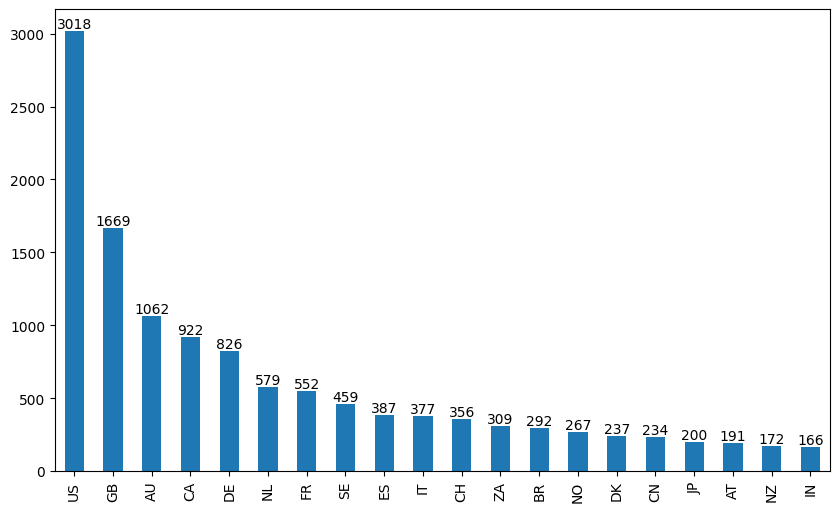

In [86]:
plt.figure(figsize=(10, 6))
data_counts[:20].plot(kind='bar')
ax = data_counts[:20].plot(kind='bar')
for i, v in enumerate(data_counts[:20]):
    ax.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.show()

Find the data for constructing the learning model ( IPBES related or not )

In [87]:
df_ipbes['year'] = pd.to_numeric(df_ipbes['year'], errors='coerce')
year=df_ipbes.drop_duplicates(subset='doi')['year'].dropna().sort_values().apply(lambda x: int(x))
year_counts = pd.Series(list(year)).value_counts().to_dict()

In [88]:
dois=list(df_unique_doi.doi)

In [89]:
year_counts_not_ipbes={}
target_iterations = len(dois)

In [90]:
for year in list(year_counts.keys()):   
    cached_openalex_data_not_ipbes[year]=[]
    year_counts_not_ipbes[year]=0
    while year_counts_not_ipbes[year]<year_counts[year]:
        get_open_alex_data_not_in_references(dois,cached_openalex_data_not_ipbes,year_counts,year_counts_not_ipbes,year)
    cached_openalex_data_not_ipbes[year]=cached_openalex_data_not_ipbes[year][:year_counts[year]+1]

plus que 702 publications pour completer l'année 2016
plus que 608 publications pour completer l'année 2016
plus que 512 publications pour completer l'année 2016
plus que 422 publications pour completer l'année 2016
plus que 326 publications pour completer l'année 2016
plus que 227 publications pour completer l'année 2016
plus que 141 publications pour completer l'année 2016
plus que 56 publications pour completer l'année 2016
plus que 623 publications pour completer l'année 2017
plus que 529 publications pour completer l'année 2017
plus que 437 publications pour completer l'année 2017
plus que 343 publications pour completer l'année 2017
plus que 245 publications pour completer l'année 2017
plus que 147 publications pour completer l'année 2017
plus que 55 publications pour completer l'année 2017
plus que 620 publications pour completer l'année 2015
plus que 533 publications pour completer l'année 2015
plus que 447 publications pour completer l'année 2015
plus que 353 publications pour

In [91]:
len(cached_openalex_data_not_ipbes)

70

In [92]:
write_cache(cached_openalex_data_not_ipbes,module_path+'\\IPCC_bibliography\\AR6\\structured_data\\cached_openalex_data_not_ipbes.pkl')

In [93]:
df_not_ipbes=pd.DataFrame()
year_list = []
countries_list = []
concepts_list = []
sdg_list = []
topics_list = []
dois_list = []
for k in range(len(aplatir(list(cached_openalex_data_not_ipbes.values())))):
    countries,concepts,sdg,year,topics,doi=get_countries_concepts_sdg(cached_openalex_data=aplatir(list(cached_openalex_data_not_ipbes.values())),ipcc=False,i=k)

    countries_list.append(countries)
    concepts_list.append(concepts)
    sdg_list.append(sdg)
    year_list.append(year)   
    topics_list.append(topics)   
    dois_list.append(doi)   

df_not_ipbes['countries'] = countries_list
df_not_ipbes['concepts'] = concepts_list
df_not_ipbes['sdg'] = sdg_list
df_not_ipbes['year'] = year_list
df_not_ipbes['topics'] = topics_list
df_not_ipbes['doi'] = dois_list

In [94]:
df_not_ipbes

,countries,concepts,sdg,year,topics,doi
0,[US],"[{'name': 'Medicine'}, {'name': 'Specialty'}, ...","[{'id': '3', 'name': 'Good health and well-bei...",2016,[{'name': 'Molecular Mechanisms of Cardiac Arr...,https://doi.org/10.1161/circep.116.003612
1,[None],"[{'name': 'Business'}, {'name': 'Tourism'}, {'...","[{'id': '8', 'name': 'Decent work and economic...",2016,[{'name': 'Factors Influencing Wine Tourism an...,https://doi.org/10.4135/9781473982871.n21
2,[EG],"[{'name': 'Medicine'}, {'name': 'Anesthesia'},...","[{'id': '2', 'name': 'Zero hunger'}]",2016,[{'name': 'Management of Postoperative Pain an...,https://doi.org/10.4103/1687-7934.179906
3,[],"[{'name': 'Medicine'}, {'name': 'Dermatology'}]","[{'id': '3', 'name': 'Good health and well-bei...",2016,[{'name': 'Health Risks in Children and Adoles...,https://doi.org/10.25207/1608-6228-2016-1-83-87
4,[PL],"[{'name': 'Biology'}, {'name': 'Ixodes ricinus...","[{'id': '15', 'name': 'Life on land'}]",2016,[{'name': 'Tick-Borne Diseases and Pathogens T...,https://doi.org/10.17420/ap6201.25
...,...,...,...,...,...,...
6646,[US],"[{'name': 'Medicine'}, {'name': 'Gallstones'},...","[{'id': '3', 'name': 'Good health and well-bei...",1943,[{'name': 'Complications of Gallstone Disease'...,https://doi.org/10.1016/s0002-9610(43)90578-1
6647,[],"[{'name': 'Spondylolisthesis'}, {'name': 'Comp...","[{'id': '2', 'name': 'Zero hunger'}]",1936,[{'name': 'Pathophysiology of Lumbar Disc Dege...,https://doi.org/10.1136/bmj.2.3956.894-b
6648,[],"[{'name': 'Ehlers–Danlos syndrome'}, {'name': ...","[{'id': '4', 'name': 'Quality education'}]",1936,[{'name': 'Genetic Disorders Causing Tissue Mi...,https://doi.org/10.1111/j.1365-2133.1936.tb100...
6649,[CN],"[{'name': 'Bacteroides fragilis'}, {'name': 'O...","[{'id': '3', 'name': 'Good health and well-bei...",2024,[{'name': 'Blood-Brain Barrier and Neurovascul...,https://doi.org/10.1080/15384101.2024.2309005


In [ ]:
#df_not_ipbes.to_json(module_path+f'\\IPCC_bibliography\\AR6\\structured_data\\data_not_ipbes.jsonl', orient='records', lines= True)